In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import uniform as sp_uniform

import warnings
warnings.filterwarnings("ignore")

## 1

In [2]:
df = pd.read_csv('biden.csv')
df.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 6 columns):
biden     1807 non-null int64
female    1807 non-null int64
age       1807 non-null int64
educ      1807 non-null int64
dem       1807 non-null int64
rep       1807 non-null int64
dtypes: int64(6)
memory usage: 84.8 KB


## a)

In [4]:
X = df[['female','age','dem','rep','educ']]
y = df[['biden']]

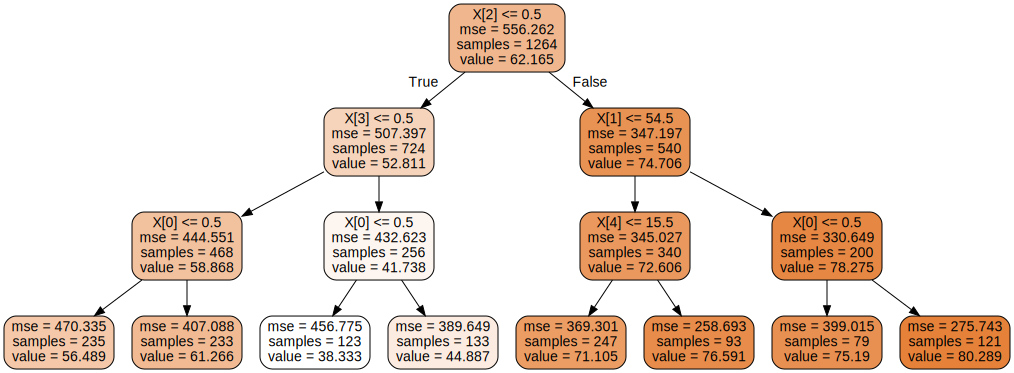

In [5]:
from sklearn.tree import export_graphviz
import graphviz
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=25)
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_train = biden_tree.fit(X_train,y_train)
biden_tree_ = export_graphviz(biden_tree,out_file=None,rounded=True,filled=True)

graph = graphviz.Source(biden_tree_)
graph.render('biden_tree_')
graph

In [6]:
y_pred_1 = biden_tree.predict(X_test)
mse_1 = mean_squared_error(y_pred_1, y_test)
print('MSE = {}'.format(mse_1))

MSE = 396.1937146321307


The result shows that the decision tree splits the predictors into eight terminals. The first node is dem. Then the left branch is splited by rep and right branch is splited by age. The four nodes in the third level are further divided by feamle, female, educ and female. The mse of test set is 396.19 overall，while the maximum is 470.34 and the minimum is 258.69. The most accurate estimation is when dem = 1, age <= 54.5, educ <=15.5.

## b)

In [7]:
param_dist1 = {'max_depth': [3, 10],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20)}
random_search = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=param_dist1,
                                   n_iter=100, n_jobs=-1, cv=5, random_state=25, 
                                   scoring='neg_mean_squared_error')
rs_fit1 = random_search.fit(X_train, y_train)
print(rs_fit1.best_params_)
print('MSE = {}'.format(abs(rs_fit1.best_score_)))


{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
MSE = 404.7488359884144


## c)

In [8]:
param_dist2 = {'n_estimators': [10, 200],
                'max_depth': [3, 10],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 5)}
random_forest = RandomForestRegressor()
random_search2 = RandomizedSearchCV(random_forest, param_distributions=param_dist2,
                                    n_iter=100, n_jobs=-1, cv=5, random_state=25, 
                                    scoring='neg_mean_squared_error')
rs_fit2 = random_search2.fit(X_train, y_train)
print(rs_fit2.best_params_)
print("MSE = ", abs(rs_fit2.best_score_))

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 19, 'min_samples_split': 11, 'n_estimators': 200}
MSE =  398.20082310762285


## 2

In [9]:
df = pd.read_csv('Auto.csv', na_values='?')
df.columns=['mpg', 'cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn','name']
df['mpg_high'] = (df['mpg']>=df['mpg'].median()).astype('int')
df.dropna(inplace=True)

In [10]:
from sklearn.linear_model import LogisticRegression
df_orgn = pd.get_dummies(df.orgn, prefix='orgn').iloc[:, :-1]
df = pd.concat([df, df_orgn], axis=1)

In [11]:
df.head()

,mpg,cyl,displ,hpwr,wgt,accl,yr,orgn,name,mpg_high,orgn_1,orgn_2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 12 columns):
mpg         392 non-null float64
cyl         392 non-null int64
displ       392 non-null float64
hpwr        392 non-null float64
wgt         392 non-null int64
accl        392 non-null float64
yr          392 non-null int64
orgn        392 non-null int64
name        392 non-null object
mpg_high    392 non-null int64
orgn_1      392 non-null uint8
orgn_2      392 non-null uint8
dtypes: float64(4), int64(5), object(1), uint8(2)
memory usage: 34.5+ KB


## a)

In [13]:
k = 4
kf = KFold(k, shuffle=True, random_state=25)
Xvars = df[['cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn_1', 'orgn_2']].values
yvars = df.mpg_high.values
kf.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(k)
y_test_lst2 = np.zeros(df.shape[0])
y_pred_lst2 = np.zeros(df.shape[0])

In [14]:
k_ind = int(0)
err1_vec = np.zeros(4)
err0_vec = np.zeros(4)

for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    err1 = np.sum((y_test!=y_pred)&(y_test==1))/np.sum(y_test==1)
    err0 = np.sum((y_test!=y_pred)&(y_test==0))/np.sum(y_test==0)
    err1_vec[k_ind] = err1 
    err0_vec[k_ind] = err0
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()    
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
err1_avg = err1_vec.mean()
err0_avg = err0_vec.mean()

print('Test estimate MSE k-fold = {}.'.format(MSE_kf))
print('Overall error rate for mpg_high=1 is {}.'.format(err1_avg))
print('Overall error rate for mpg_high=0 is {}.'.format(err0_avg))

Test estimate MSE k-fold = 0.09693877551020408.
Overall error rate for mpg_high=1 is 0.07941477339674582.
Overall error rate for mpg_high=0 is 0.11364706285146922.


## b)

In [15]:
random_forest = RandomForestClassifier()
param_dist3 = {'n_estimators': [10, 200],
                'max_depth': [3, 8],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 8)}
random_search3 = RandomizedSearchCV(random_forest, param_distributions=param_dist3,
                                   n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
rs_fit3 = random_search3.fit(Xvars, yvars)

print(rs_fit3.best_params_)
print('MSE = ', abs(rs_fit3.best_score_))

{'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 19, 'n_estimators': 10}
MSE =  0.08163265306122448


## c)

In [16]:
param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]}
svc = SVC(kernel='rbf')
random_search4 = RandomizedSearchCV(svc, param_distributions=param_dist4, n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
rs_fit4 = random_search4.fit(Xvars, yvars)
print(rs_fit4.best_params_)
print('MSE = ', abs(rs_fit4.best_score_))

{'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}
MSE =  0.11989795918367346


## d)

I think the best predictor of mpg_high is Random Forest Classifier, because this model has the smallest MSE.